In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pyplot as plt
from collections import Counter
import ipywidgets as widgets
from ipywidgets import interact
import random
from imblearn.under_sampling import EditedNearestNeighbours


In [2]:
X, y = make_classification(n_samples=700, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42, weights=[0.1, 0.9])

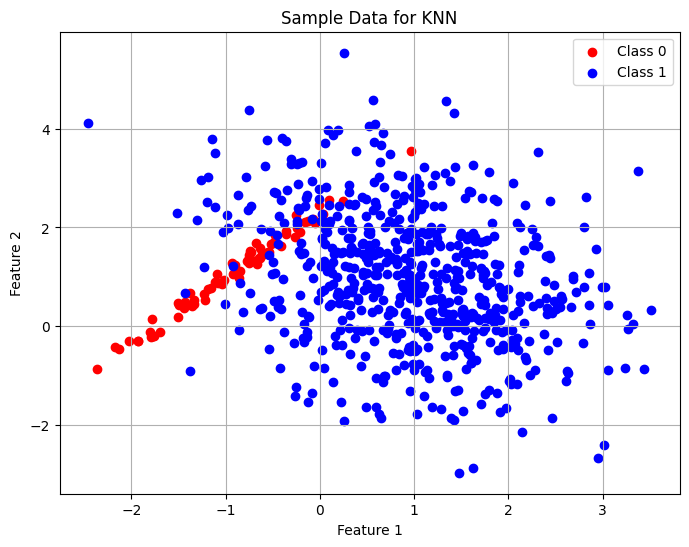

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Sample Data for KNN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
@interact(
    k=widgets.IntSlider(min=1, max=10, step=1, value=5, description='k-neighbors'),
    balance=widgets.FloatSlider(min=0, max=1, step=0.1, value=1, description='Balance Ratio')
)
def plot_smote(k, balance):
    # Identify minority and majority classes
    minority_class = np.argmin(np.bincount(y))
    majority_class = np.argmax(np.bincount(y))

    # Extract instances of the minority class
    minority_instances = X[y == minority_class]

    # Initialize NearestNeighbors model
    nn = NearestNeighbors(n_neighbors=k+1)  # +1 to include the point itself
    nn.fit(minority_instances)

    # Find k nearest neighbors for each instance in the minority class
    distances, indices = nn.kneighbors(minority_instances)

    # Initialize an empty list to store synthetic samples
    synthetic_samples = []

    # Generate synthetic samples until the balance ratio is achieved
    while True:
        new_synthetic_samples = []
        for i in range(len(minority_instances)):
            for j in range(1, k+1):  # start from 1 to skip the point itself
                # Select a random neighbor (excluding itself)
                neighbor_index = random.choice(indices[i][1:])  # Avoid choosing itself (index 0)
                neighbor = minority_instances[neighbor_index]

                # Generate a random number between 0 and 1
                delta = np.random.rand()

                # Create a synthetic sample
                synthetic_sample = minority_instances[i] + delta * (neighbor - minority_instances[i])

                # Append the synthetic sample to the list
                new_synthetic_samples.append(synthetic_sample)

        # Convert new synthetic samples to numpy array
        new_synthetic_samples = np.array(new_synthetic_samples)
        synthetic_samples.extend(new_synthetic_samples)

        # Calculate the number of samples needed for balance
        num_minority = np.sum(y == minority_class)
        num_majority = np.sum(y == majority_class)
        num_needed = int((num_majority - num_minority) * balance)

        # Check if the balance ratio is achieved
        if len(synthetic_samples) >= num_needed:
            synthetic_samples = synthetic_samples[:num_needed]
            break

    # Append synthetic samples to the original data
    X_balanced = np.vstack((X, synthetic_samples))
    y_balanced = np.hstack((y, [minority_class] * len(synthetic_samples)))

    # Plotting
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    ax = ax.ravel()

    # Original Data
    ax[0].scatter(X[y == majority_class][:, 0], X[y == majority_class][:, 1], color='blue', label='Majority Class')
    ax[0].scatter(X[y == minority_class][:, 0], X[y == minority_class][:, 1], color='red', label='Minority Class')
    ax[0].set_title('Original Data')
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')
    ax[0].legend()
    ax[0].grid(True)

    # Balanced Data
    ax[1].scatter(X_balanced[y_balanced == majority_class][:, 0], X_balanced[y_balanced == majority_class][:, 1], color='blue', label='Majority Class')
    ax[1].scatter(X_balanced[y_balanced == minority_class][:, 0], X_balanced[y_balanced == minority_class][:, 1], color='red', label='Minority Class')
    ax[1].set_title(f'Balanced Data: class 0 -> {np.sum(y_balanced == 0)}, class 1 -> {np.sum(y_balanced == 1)}')
    ax[1].set_xlabel('Feature 1')
    ax[1].set_ylabel('Feature 2')
    ax[1].legend()
    ax[1].grid(True)

    # Set up meshgrid for decision boundary visualization
    resolution = 0.1  # Grid resolution for visualization
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )

    # Create a meshgrid for the balanced data
    x_min_balanced, x_max_balanced = X_balanced[:, 0].min() - 1, X_balanced[:, 0].max() + 1
    y_min_balanced, y_max_balanced = X_balanced[:, 1].min() - 1, X_balanced[:, 1].max() + 1
    xx_balanced, yy_balanced = np.meshgrid(
        np.arange(x_min_balanced, x_max_balanced, resolution),
        np.arange(y_min_balanced, y_max_balanced, resolution)
    )

    # Train a KNN classifier on the original data
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    # Predict on the meshgrid
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Train a KNN classifier on the balanced data
    knn_balanced = KNeighborsClassifier(n_neighbors=k)
    knn_balanced.fit(X_balanced, y_balanced)

    # Predict on the meshgrid
    Z_balanced = knn_balanced.predict(np.c_[xx_balanced.ravel(), yy_balanced.ravel()])
    Z_balanced = Z_balanced.reshape(xx_balanced.shape)

    # Original Data Decision Boundary
    ax[2].contourf(xx, yy, Z, alpha=0.4)
    ax[2].scatter(X[y == majority_class][:, 0], X[y == majority_class][:, 1], color='blue', label='Majority Class')
    ax[2].scatter(X[y == minority_class][:, 0], X[y == minority_class][:, 1], color='red', label='Minority Class')
    ax[2].set_title('Original Data Decision Boundary')
    ax[2].set_xlabel('Feature 1')
    ax[2].set_ylabel('Feature 2')
    ax[2].legend()
    ax[2].grid(True)

    # Balanced Data Decision Boundary
    ax[3].contourf(xx_balanced, yy_balanced, Z_balanced, alpha=0.4)
    ax[3].scatter(X_balanced[y_balanced == majority_class][:, 0], X_balanced[y_balanced == majority_class][:, 1], color='blue', label='Majority Class')
    ax[3].scatter(X_balanced[y_balanced == minority_class][:, 0], X_balanced[y_balanced == minority_class][:, 1], color='red', label='Minority Class')
    ax[3].set_title('Balanced Data Decision Boundary')
    ax[3].set_xlabel('Feature 1')
    ax[3].set_ylabel('Feature 2')
    ax[3].legend()
    ax[3].grid(True)

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=5, description='k-neighbors', max=10, min=1), FloatSlider(value=1.0, des…

In [5]:
@interact(
    k=widgets.IntSlider(min=1, max=10, step=1, value=3, description='k-neighbors'),
    k_enn=widgets.IntSlider(min=1, max=10, step=1, value=5, description='k-ENN'),
    balance=widgets.FloatSlider(min=0, max=1, step=0.1, value=1, description='Balance Ratio')
)
def plot_smoteenn(k, k_enn, balance):
    # Identify minority and majority classes
    minority_class = np.argmin(np.bincount(y))
    majority_class = np.argmax(np.bincount(y))

    # Extract instances of the minority class
    minority_instances = X[y == minority_class]

    # Initialize NearestNeighbors model
    nn = NearestNeighbors(n_neighbors=k+1)  # +1 to include the point itself
    nn.fit(minority_instances)

    # Find k nearest neighbors for each instance in the minority class
    distances, indices = nn.kneighbors(minority_instances)

    # Initialize an empty list to store synthetic samples
    synthetic_samples = []

    # Generate synthetic samples until the balance ratio is achieved
    while True:
        new_synthetic_samples = []
        for i in range(len(minority_instances)):
            for j in range(1, k+1):  # start from 1 to skip the point itself
                # Select a random neighbor (excluding itself)
                neighbor_index = random.choice(indices[i][1:])  # Avoid choosing itself (index 0)
                neighbor = minority_instances[neighbor_index]

                # Generate a random number between 0 and 1
                delta = np.random.rand()

                # Create a synthetic sample
                synthetic_sample = minority_instances[i] + delta * (neighbor - minority_instances[i])

                # Append the synthetic sample to the list
                new_synthetic_samples.append(synthetic_sample)

        # Convert new synthetic samples to numpy array
        new_synthetic_samples = np.array(new_synthetic_samples)
        synthetic_samples.extend(new_synthetic_samples)

        # Calculate the number of samples needed for balance
        num_minority = np.sum(y == minority_class)
        num_majority = np.sum(y == majority_class)
        num_needed = int((num_majority - num_minority) * balance)

        # Check if the balance ratio is achieved
        if len(synthetic_samples) >= num_needed:
            synthetic_samples = synthetic_samples[:num_needed]
            break

    # Append synthetic samples to the original data
    X_balanced = np.vstack((X, synthetic_samples))
    y_balanced = np.hstack((y, [minority_class] * len(synthetic_samples)))

    #apply EEN
    enn = EditedNearestNeighbours(n_neighbors=k_enn)
    X_balanced, y_balanced = enn.fit_resample(X_balanced, y_balanced)
    

    # Plotting
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    ax = ax.ravel()

    # Original Data
    ax[0].scatter(X[y == majority_class][:, 0], X[y == majority_class][:, 1], color='blue', label='Majority Class')
    ax[0].scatter(X[y == minority_class][:, 0], X[y == minority_class][:, 1], color='red', label='Minority Class')
    ax[0].set_title('Original Data')
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')
    ax[0].legend()
    ax[0].grid(True)

    # Balanced Data
    ax[1].scatter(X_balanced[y_balanced == majority_class][:, 0], X_balanced[y_balanced == majority_class][:, 1], color='blue', label='Majority Class')
    ax[1].scatter(X_balanced[y_balanced == minority_class][:, 0], X_balanced[y_balanced == minority_class][:, 1], color='red', label='Minority Class')
    ax[1].set_title(f'Balanced Data: class 0 -> {np.sum(y_balanced == 0)}, class 1 -> {np.sum(y_balanced == 1)}')
    ax[1].set_xlabel('Feature 1')
    ax[1].set_ylabel('Feature 2')
    ax[1].legend()
    ax[1].grid(True)

    # Set up meshgrid for decision boundary visualization
    resolution = 0.1  # Grid resolution for visualization
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )

    # Create a meshgrid for the balanced data
    x_min_balanced, x_max_balanced = X_balanced[:, 0].min() - 1, X_balanced[:, 0].max() + 1
    y_min_balanced, y_max_balanced = X_balanced[:, 1].min() - 1, X_balanced[:, 1].max() + 1
    xx_balanced, yy_balanced = np.meshgrid(
        np.arange(x_min_balanced, x_max_balanced, resolution),
        np.arange(y_min_balanced, y_max_balanced, resolution)
    )

    # Train a KNN classifier on the original data
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    # Predict on the meshgrid
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Train a KNN classifier on the balanced data
    knn_balanced = KNeighborsClassifier(n_neighbors=k)
    knn_balanced.fit(X_balanced, y_balanced)

    # Predict on the meshgrid
    Z_balanced = knn_balanced.predict(np.c_[xx_balanced.ravel(), yy_balanced.ravel()])
    Z_balanced = Z_balanced.reshape(xx_balanced.shape)

    # Original Data Decision Boundary
    ax[2].contourf(xx, yy, Z, alpha=0.4)
    ax[2].scatter(X[y == majority_class][:, 0], X[y == majority_class][:, 1], color='blue', label='Majority Class')
    ax[2].scatter(X[y == minority_class][:, 0], X[y == minority_class][:, 1], color='red', label='Minority Class')
    ax[2].set_title('Original Data Decision Boundary')
    ax[2].set_xlabel('Feature 1')
    ax[2].set_ylabel('Feature 2')
    ax[2].legend()
    ax[2].grid(True)

    # Balanced Data Decision Boundary
    ax[3].contourf(xx_balanced, yy_balanced, Z_balanced, alpha=0.4)
    ax[3].scatter(X_balanced[y_balanced == majority_class][:, 0], X_balanced[y_balanced == majority_class][:, 1], color='blue', label='Majority Class')
    ax[3].scatter(X_balanced[y_balanced == minority_class][:, 0], X_balanced[y_balanced == minority_class][:, 1], color='red', label='Minority Class')
    ax[3].set_title('Balanced Data Decision Boundary')
    ax[3].set_xlabel('Feature 1')
    ax[3].set_ylabel('Feature 2')
    ax[3].legend()
    ax[3].grid(True)

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=3, description='k-neighbors', max=10, min=1), IntSlider(value=5, descrip…